# Nerve - Segmentation w/ U-Net

kenstler@

Ultrasound nerve-segmentation using U-net architecture for pixel-wise classification. Adapted from Keras implementation [here](https://github.com/jocicmarko/ultrasound-nerve-segmentation). Follow instructions on that repo to prepare the data using the `data.py` script, and keep it in the same directory as this nb. We will use methods from said script to load data.

In [ ]:
import mxnet as mx
from mxnet import ndarray as F

from __future__ import print_function

import os
from skimage.transform import resize
from skimage.io import imsave
from sklearn.cross_validation import train_test_split
import numpy as np
from data import load_train_data, load_test_data
import matplotlib.pyplot as plt
%matplotlib inline

## Data

Ultrasound images and corresponding masks are loaded here.

In [2]:
batch_size = 32
img_rows = 96
img_cols = 96

In [3]:
data_shape = (batch_size, 1, img_rows, img_cols)

In [5]:
train_X, train_Y = load_train_data()
train_X, valid_X, train_Y, valid_Y = train_test_split(train_X, train_Y, test_size=0.2, random_state=1984)
test_X, test_Y = load_test_data()

In [6]:
_, class_counts = np.unique(train_Y, return_counts=True)

In [7]:
train_X.shape

(4508, 420, 580)

In [8]:
train_Y.shape

(4508, 420, 580)

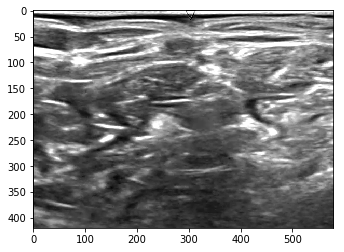

In [9]:
plt.imshow(train_X[6], cmap=plt.cm.gray)

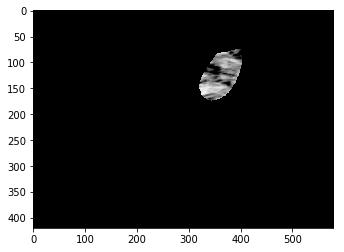

In [11]:
plt.imshow(train_X[6]*train_Y[6], cmap=plt.cm.gray)

Preprocessing includes mean-centering, normalization, and resizing original images to 96x96.

In [12]:
train_mean = np.mean(train_X) 
train_std = np.std(train_X)

In [13]:
def preprocess(imgs, mean = train_mean, std = train_std, test=False):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(imgs[i], (img_cols, img_rows), preserve_range=True)

    imgs_p = np.expand_dims(imgs_p, axis=1)
    if test:
        imgs_p = imgs_p / 255.
        imgs_p = np.round(imgs_p).astype('uint8')
    else:
        imgs_p = imgs_p.astype('float32')
        imgs_p -= mean
        imgs_p /= std
    return imgs_p

We're also going to flatten our masks.

In [14]:
train_X = preprocess(train_X)
train_Y = preprocess(train_Y, test=True)
train_Y = train_Y.reshape((len(train_Y), img_rows*img_cols))
valid_X = preprocess(valid_X)
valid_Y = preprocess(valid_Y, test=True)
valid_Y = valid_Y.reshape((len(valid_Y), img_rows*img_cols))
test_X = preprocess(test_X)

/home/ubuntu/src/anaconda2/envs/mxnet1/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [15]:
def post_process(imgs, mean = train_mean, std = train_std):
    imgs_p = imgs.copy()
    imgs_p *= std
    imgs_p += mean
    imgs_p = imgs_p.astype('uint8')
    if len(imgs_p.shape)==4:
        return imgs_p[:,0,:,:]
    else:
        return imgs_p[0, :, :]

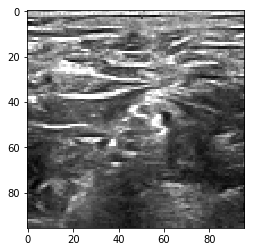

In [16]:
plt.imshow(post_process(train_X[1]), cmap=plt.cm.gray)

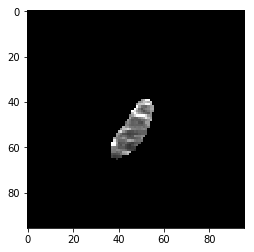

In [17]:
plt.imshow(post_process(train_X[1])*(train_Y[1].reshape(img_cols, img_rows)).astype('uint8'), cmap=plt.cm.gray)

## Model

We will be using the dice coefficient as our loss by optimizing it's negative.

In [4]:
def dice_coef(y_true, y_pred):
    intersection = mx.sym.sum(mx.sym.broadcast_mul(y_true, y_pred), axis=(1, 2, 3))
    return mx.sym.broadcast_div((2. * intersection + 1.),(mx.sym.sum(y_true, axis=(1, 2, 3)) + mx.sym.sum(y_pred, axis=(1, 2, 3)) + 1.))


def dice_coef_loss(y_true, y_pred):
    intersection = mx.sym.sum(mx.sym.broadcast_mul(y_true, y_pred), axis=1, )
    return -mx.sym.broadcast_div((2. * intersection + 1.),(mx.sym.broadcast_add(mx.sym.sum(y_true, axis=1), mx.sym.sum(y_pred, axis=1)) + 1.))

Unet architecture w/ batch normalization.

In [5]:
def build_unet():
    data = mx.sym.Variable(name='data')
    label = mx.sym.Variable(name='label')
    conv1 = mx.sym.Convolution(data, num_filter=32, kernel=(3,3), pad=(1,1), name='conv1_1')
    conv1 = mx.sym.BatchNorm(conv1, name='bn1_1')
    conv1 = mx.sym.Activation(conv1, act_type='relu', name='relu1_1')
    conv1 = mx.sym.Convolution(conv1, num_filter=32, kernel=(3,3), pad=(1,1), name='conv1_2')
    conv1 = mx.sym.BatchNorm(conv1, name='bn1_2')
    conv1 = mx.sym.Activation(conv1, act_type='relu', name='relu1_2')
    pool1 = mx.sym.Pooling(conv1, kernel=(2,2), pool_type='max', name='pool1')
    
    conv2 = mx.sym.Convolution(pool1, num_filter=64, kernel=(3,3), pad=(1,1), name='conv2_1')
    conv2 = mx.sym.BatchNorm(conv2, name='bn2_1')
    conv2 = mx.sym.Activation(conv2, act_type='relu', name='relu2_1')
    conv2 = mx.sym.Convolution(conv2, num_filter=64, kernel=(3,3), pad=(1,1), name='conv2_2')
    conv2 = mx.sym.BatchNorm(conv2, name='bn2_2')
    conv2 = mx.sym.Activation(conv2, act_type='relu', name='relu2_2')
    pool2 = mx.sym.Pooling(conv2, kernel=(2,2), pool_type='max', name='pool2')
    
    conv3 = mx.sym.Convolution(pool2, num_filter=128, kernel=(3,3), pad=(1,1), name='conv3_1')
    conv3 = mx.sym.BatchNorm(conv3, name='bn3_1')
    conv3 = mx.sym.Activation(conv3, act_type='relu', name='relu3_1')
    conv3 = mx.sym.Convolution(conv3, num_filter=128, kernel=(3,3), pad=(1,1), name='conv3_2')
    conv3 = mx.sym.BatchNorm(conv3, name='bn3_2')
    conv3 = mx.sym.Activation(conv3, act_type='relu', name='relu3_2')
    pool3 = mx.sym.Pooling(conv3, kernel=(2,2), pool_type='max', name='pool3')
    
    conv4 = mx.sym.Convolution(pool3, num_filter=256, kernel=(3,3), pad=(1,1), name='conv4_1')
    conv4 = mx.sym.BatchNorm(conv4, name='bn4_1')
    conv4 = mx.sym.Activation(conv4, act_type='relu', name='relu4_1')
    conv4 = mx.sym.Convolution(conv4, num_filter=256, kernel=(3,3), pad=(1,1), name='conv4_2')
    conv4 = mx.sym.BatchNorm(conv4, name='bn4_2')
    conv4 = mx.sym.Activation(conv4, act_type='relu', name='relu4_2')
    pool4 = mx.sym.Pooling(conv4, kernel=(2,2), pool_type='max', name='pool4')
    
    conv5 = mx.sym.Convolution(pool4, num_filter=512, kernel=(3,3), pad=(1,1), name='conv5_1')
    conv5 = mx.sym.BatchNorm(conv5, name='bn5_1')
    conv5 = mx.sym.Activation(conv5, act_type='relu', name='relu5_1')
    conv5 = mx.sym.Convolution(conv5, num_filter=512, kernel=(3,3), pad=(1,1), name='conv5_2')
    conv5 = mx.sym.BatchNorm(conv5, name='bn5_2')
    conv5 = mx.sym.Activation(conv5, act_type='relu', name='relu5_2')
    
    trans_conv6 = mx.sym.Deconvolution(conv5, num_filter=256, kernel=(2,2), stride=(1,1), no_bias=True, name='trans_conv6')
    up6 = mx.sym.concat(*[trans_conv6, conv4], dim=1, name='concat6')
    conv6 = mx.sym.Convolution(up6, num_filter=256, kernel=(3,3), pad=(1,1), name='conv6_1')
    conv6 = mx.sym.BatchNorm(conv6, name='bn6_1')
    conv6 = mx.sym.Activation(conv6, act_type='relu', name='relu6_1')
    conv6 = mx.sym.Convolution(conv6, num_filter=256, kernel=(3,3), pad=(1,1), name='conv6_2')
    conv6 = mx.sym.BatchNorm(conv6, name='bn6_2')
    conv6 = mx.sym.Activation(conv6, act_type='relu', name='relu6_2')
    
    trans_conv7 = mx.sym.Deconvolution(conv6, num_filter=128, kernel=(2,2), stride=(1,1), no_bias=True, name='trans_conv7')
    up7 = mx.sym.concat(*[trans_conv7, conv3], dim=1, name='concat7')
    conv7 = mx.sym.Convolution(up7, num_filter=128, kernel=(3,3), pad=(1,1), name='conv7_1')
    conv7 = mx.sym.BatchNorm(conv7, name='bn7_1')
    conv7 = mx.sym.Activation(conv7, act_type='relu', name='relu7_1')
    conv7 = mx.sym.Convolution(conv7, num_filter=128, kernel=(3,3), pad=(1,1), name='conv7_2')
    conv7 = mx.sym.BatchNorm(conv7, name='bn7_2')
    conv7 = mx.sym.Activation(conv7, act_type='relu', name='relu7_2')
    
    trans_conv8 = mx.sym.Deconvolution(conv7, num_filter=64, kernel=(2,2), stride=(1,1), no_bias=True, name='trans_conv8')
    up8 = mx.sym.concat(*[trans_conv8, conv2], dim=1, name='concat8')
    conv8 = mx.sym.Convolution(up8, num_filter=64, kernel=(3,3), pad=(1,1), name='conv8_1')
    conv8 = mx.sym.BatchNorm(conv8, name='bn8_1')
    conv8 = mx.sym.Activation(conv8, act_type='relu', name='relu8_1')
    conv8 = mx.sym.Convolution(conv8, num_filter=64, kernel=(3,3), pad=(1,1), name='conv8_2')
    conv8 = mx.sym.BatchNorm(conv8, name='bn8_2')
    conv8 = mx.sym.Activation(conv8, act_type='relu', name='relu8_2')
    
    trans_conv9 = mx.sym.Deconvolution(conv8, num_filter=32, kernel=(2,2), stride=(1,1), no_bias=True, name='trans_conv9')
    up9 = mx.sym.concat(*[trans_conv9, conv1], dim=1, name='concat9')
    conv9 = mx.sym.Convolution(up9, num_filter=32, kernel=(3,3), pad=(1,1), name='conv9_1')
    conv9 = mx.sym.BatchNorm(conv9, name='bn9_1')
    conv9 = mx.sym.Activation(conv9, act_type='relu', name='relu9_1')
    conv9 = mx.sym.Convolution(conv9, num_filter=32, kernel=(3,3), pad=(1,1), name='conv9_2')
    conv9 = mx.sym.BatchNorm(conv9, name='bn9_2')
    conv9 = mx.sym.Activation(conv9, act_type='relu', name='relu9_2')
    
    conv10 = mx.sym.Convolution(conv9, num_filter=1, kernel=(1,1), name='conv10_1')
    conv10 = mx.sym.sigmoid(conv10, name='softmax')
    
    net = mx.sym.Flatten(conv10)
    loss = mx.sym.MakeLoss(dice_coef_loss(label, net), normalization='batch')
    mask_output = mx.sym.BlockGrad(conv10, 'mask')
    out = mx.sym.Group([loss, mask_output])
#     return mx.sym.Custom(net, pos_grad_scale = pos, neg_grad_scale = neg, name = 'softmax', op_type = 'weighted_logistic_regression')
#     return mx.sym.LogisticRegressionOutput(net, name='softmax')
    return out

In [6]:
ctx = [mx.gpu(i) for i in range(8)]

In [7]:
unet_sym = build_unet()
unet = mx.mod.Module(unet_sym, context=ctx,data_names=('data',), label_names=('label',))
unet.bind(data_shapes=[['data', data_shape]], label_shapes=[['label', (batch_size, img_cols*img_rows)]])
unet.init_params(mx.initializer.Xavier(magnitude=6))

unet.init_optimizer(optimizer = 'adam', 
                               optimizer_params=(
                                   ('learning_rate', 1E-4),
                                   ('beta1', 0.9),
                                   ('beta2', 0.99)
                              ))

In [332]:
train_iter = mx.io.NDArrayIter(data = train_X, label=train_Y, batch_size=batch_size, label_name='label', shuffle=True)

val_iter = mx.io.NDArrayIter(data = valid_X, label=valid_Y, batch_size=batch_size, label_name='label', shuffle=False)


In [63]:
import logging
logging.getLogger().setLevel(logging.DEBUG)

Training loop. Saves best model on validation loss.

In [335]:
epochs = 100
smoothing_constant = .01
curr_losses = []
moving_losses = []
i = 0
best_val_loss = np.inf
for e in range(epochs):
    while True:
        try:
            batch = next(train_iter)
        except StopIteration:
            train_iter.reset()
            break
        unet.forward_backward(batch)
        loss = unet.get_outputs()[0]
        unet.update()
        curr_loss = F.mean(loss).asscalar()
        curr_losses.append(curr_loss)
        moving_loss = (curr_loss if ((i == 0) and (e == 0))
                               else (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss)
        moving_losses.append(moving_loss)
        i += 1
    val_losses = []
    for batch in val_iter:
        unet.forward(batch)
        loss = unet.get_outputs()[0]
        val_losses.append(F.mean(loss).asscalar())
    val_iter.reset()
    val_loss = np.mean(val_losses)
    if e > 20 and val_loss < best_val_loss:
        best_val_loss = val_loss
        unet.save_checkpoint('best_unet', 0)
        print("Best model at Epoch %i" %(e+1))
    print("Epoch %i: Moving Training Loss %0.5f, Validation Loss %0.5f" % (e+1, moving_loss, val_loss))
    

Epoch 1: Moving Training Loss -0.08519, Validation Loss -0.13640
Epoch 2: Moving Training Loss -0.14094, Validation Loss -0.16745
Epoch 3: Moving Training Loss -0.17312, Validation Loss -0.18187
Epoch 4: Moving Training Loss -0.19683, Validation Loss -0.19442
Epoch 5: Moving Training Loss -0.21657, Validation Loss -0.21293
Epoch 6: Moving Training Loss -0.23555, Validation Loss -0.22890
Epoch 7: Moving Training Loss -0.25108, Validation Loss -0.23755
Epoch 8: Moving Training Loss -0.26500, Validation Loss -0.24491
Epoch 9: Moving Training Loss -0.27997, Validation Loss -0.25844
Epoch 10: Moving Training Loss -0.29100, Validation Loss -0.26039
Epoch 11: Moving Training Loss -0.30139, Validation Loss -0.27129
Epoch 12: Moving Training Loss -0.31167, Validation Loss -0.27418
Epoch 13: Moving Training Loss -0.32149, Validation Loss -0.27037
Epoch 14: Moving Training Loss -0.32888, Validation Loss -0.28313
Epoch 15: Moving Training Loss -0.33569, Validation Loss -0.29314
Epoch 16: Moving Tr

INFO:root:Saved checkpoint to "best_unet-0000.params"


Best model at Epoch 22
Epoch 22: Moving Training Loss -0.39848, Validation Loss -0.33716


INFO:root:Saved checkpoint to "best_unet-0000.params"


Best model at Epoch 23
Epoch 23: Moving Training Loss -0.41848, Validation Loss -0.33903


INFO:root:Saved checkpoint to "best_unet-0000.params"


Best model at Epoch 24
Epoch 24: Moving Training Loss -0.43883, Validation Loss -0.37535


INFO:root:Saved checkpoint to "best_unet-0000.params"


Best model at Epoch 25
Epoch 25: Moving Training Loss -0.45622, Validation Loss -0.39797


INFO:root:Saved checkpoint to "best_unet-0000.params"


Best model at Epoch 26
Epoch 26: Moving Training Loss -0.47870, Validation Loss -0.44039


INFO:root:Saved checkpoint to "best_unet-0000.params"


Best model at Epoch 27
Epoch 27: Moving Training Loss -0.50846, Validation Loss -0.46196


INFO:root:Saved checkpoint to "best_unet-0000.params"


Best model at Epoch 28
Epoch 28: Moving Training Loss -0.53855, Validation Loss -0.48380


INFO:root:Saved checkpoint to "best_unet-0000.params"


Best model at Epoch 29
Epoch 29: Moving Training Loss -0.56428, Validation Loss -0.51343


INFO:root:Saved checkpoint to "best_unet-0000.params"


Best model at Epoch 30
Epoch 30: Moving Training Loss -0.55425, Validation Loss -0.54715


INFO:root:Saved checkpoint to "best_unet-0000.params"


Best model at Epoch 31
Epoch 31: Moving Training Loss -0.56531, Validation Loss -0.55644


INFO:root:Saved checkpoint to "best_unet-0000.params"


Best model at Epoch 32
Epoch 32: Moving Training Loss -0.59385, Validation Loss -0.56605


INFO:root:Saved checkpoint to "best_unet-0000.params"


Best model at Epoch 33
Epoch 33: Moving Training Loss -0.60645, Validation Loss -0.61197
Epoch 34: Moving Training Loss -0.62961, Validation Loss -0.57995
Epoch 35: Moving Training Loss -0.63495, Validation Loss -0.59262
Epoch 36: Moving Training Loss -0.64299, Validation Loss -0.60536
Epoch 37: Moving Training Loss -0.65929, Validation Loss -0.60055
Epoch 38: Moving Training Loss -0.65807, Validation Loss -0.60428


INFO:root:Saved checkpoint to "best_unet-0000.params"


Best model at Epoch 39
Epoch 39: Moving Training Loss -0.65419, Validation Loss -0.65319
Epoch 40: Moving Training Loss -0.66291, Validation Loss -0.63549
Epoch 41: Moving Training Loss -0.65988, Validation Loss -0.58070
Epoch 42: Moving Training Loss -0.60071, Validation Loss -0.58907
Epoch 43: Moving Training Loss -0.58932, Validation Loss -0.59185
Epoch 44: Moving Training Loss -0.58802, Validation Loss -0.59340
Epoch 45: Moving Training Loss -0.58856, Validation Loss -0.59432
Epoch 46: Moving Training Loss -0.58921, Validation Loss -0.59490
Epoch 47: Moving Training Loss -0.58970, Validation Loss -0.59529
Epoch 48: Moving Training Loss -0.59005, Validation Loss -0.59555
Epoch 49: Moving Training Loss -0.59030, Validation Loss -0.59574
Epoch 50: Moving Training Loss -0.59047, Validation Loss -0.59587
Epoch 51: Moving Training Loss -0.59059, Validation Loss -0.59596
Epoch 52: Moving Training Loss -0.59068, Validation Loss -0.59603
Epoch 53: Moving Training Loss -0.59074, Validation L

KeyboardInterrupt: 

In [218]:
epochs = 20
smoothing_constant = .01
for e in range(epochs):
    while True:
        try:
            batch = next(train_iter)
        except StopIteration:
            train_iter.reset()
            break
        unet.forward_backward(batch)
        loss = unet.get_outputs()[0]
        unet.update()
        curr_loss = F.mean(loss).asscalar()
        curr_losses.append(curr_loss)
        moving_loss = (curr_loss if ((i == 0) and (e == 0))
                               else (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss)
        moving_losses.append(moving_loss)
        i += 1
    val_losses = []
    for batch in val_iter:
        unet.forward(batch)
        loss = unet.get_outputs()[0]
        val_losses.append(F.mean(loss).asscalar())
    val_iter.reset()
    val_loss = np.mean(val_losses)
    print("Epoch %i: Moving Training Loss %0.5f, Validation Loss %0.5f" % (e+21, moving_loss, val_loss))

Epoch 21: Moving Training Loss -0.28446, Validation Loss -0.22898
Epoch 22: Moving Training Loss -0.28671, Validation Loss -0.22918
Epoch 23: Moving Training Loss -0.28803, Validation Loss -0.22628
Epoch 24: Moving Training Loss -0.29093, Validation Loss -0.22953
Epoch 25: Moving Training Loss -0.29446, Validation Loss -0.22560
Epoch 26: Moving Training Loss -0.29743, Validation Loss -0.22602
Epoch 27: Moving Training Loss -0.29959, Validation Loss -0.22668
Epoch 28: Moving Training Loss -0.30181, Validation Loss -0.22123
Epoch 29: Moving Training Loss -0.30410, Validation Loss -0.23067
Epoch 30: Moving Training Loss -0.30666, Validation Loss -0.23304
Epoch 31: Moving Training Loss -0.30911, Validation Loss -0.23213
Epoch 32: Moving Training Loss -0.31153, Validation Loss -0.23487
Epoch 33: Moving Training Loss -0.31382, Validation Loss -0.23522
Epoch 34: Moving Training Loss -0.31535, Validation Loss -0.23875
Epoch 35: Moving Training Loss -0.31678, Validation Loss -0.24137
Epoch 36: 

You'll notice I stopped early. The model will often times end up converging to a bad minima, that is it predicts everything as zero.

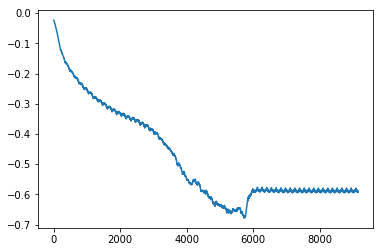

In [336]:
plt.plot(moving_losses)

We've saved the model at the lowest point here, before it plateaus into converges to this bad minima.

Let's check this model out. At ~65% dice coefficient, this gets pretty close to the results achieved in the implementation this was adapted from.

In [8]:
sym, arg_params, aux_params = mx.model.load_checkpoint('best_unet', 0)

In [9]:
unet.set_params(arg_params, aux_params)

In [10]:
unet.save_checkpoint('unet_nerve_segmentation', 39)

In [473]:
def post_process_mask(label, p=0.5):
    return (np.where(label.asnumpy().reshape(img_cols, img_rows) > p, 1, 0)).astype('uint8')

In [504]:
batch = next(val_iter)

unet.forward(batch)

outputs = unet.get_outputs()[1]

In [509]:
idx = 1

True Label

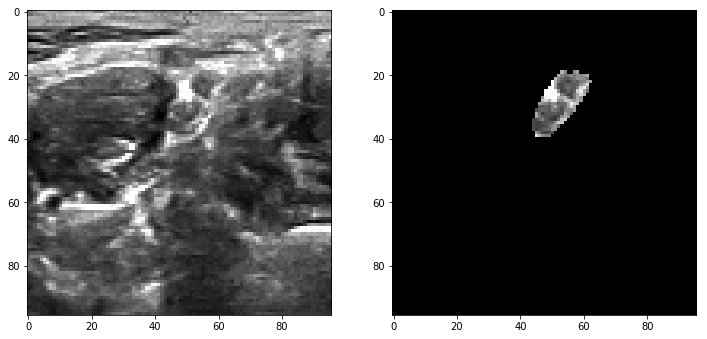

In [510]:
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.subplot(121)
plt.imshow(post_process(batch.data[0][idx]).asnumpy(), cmap=plt.cm.gray)
plt.subplot(122)
plt.imshow(post_process(batch.data[0][idx]).asnumpy()*post_process_mask(batch.label[0][idx]), cmap=plt.cm.gray)

Predicted

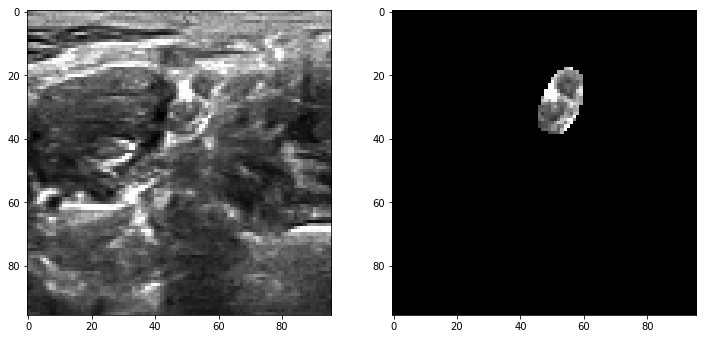

In [511]:
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.subplot(121)
plt.imshow(post_process(batch.data[0][idx]).asnumpy(), cmap=plt.cm.gray)
plt.subplot(122)
plt.imshow(post_process(batch.data[0][idx]).asnumpy()*post_process_mask(outputs[idx]), cmap=plt.cm.gray)

These results are qualitatively promising. However, while highly specific this model isn't very sensitive. Further exploration can be done to select a more qualitatively pleasing model at an earlier iteration that balances positive / negative rates out.